# This is a Demo of IDioM applied to Alanine dipeptide (Ala2).
This can also be used to reproduce the relevant results in the paper "Learning Clustered Representatio n for Complex Free Energy Landscapes" by Zhang et al.

First import basic libraries:

In [1]:
from __future__ import division, print_function, absolute_import
from __future__ import unicode_literals
import os

import math
import numpy as np

%matplotlib inline
import matplotlib
### matplotlib.use('Agg')
import matplotlib.pyplot as plt

Import tensorflow; version: 

In [2]:
import tensorflow as tf

import tflib as lib
import tflib.ops.linear

Define basic building blocks:

In [3]:
def LeakyReLU(x, alpha=0.2):
    return tf.maximum(alpha*x, x)

def LeakyReLULayer(name, n_in, n_out, inputs):
    output = lib.ops.linear.Linear(
        name+'.Linear', 
        n_in, 
        n_out, 
        inputs,
        initialization='he'
    )
    return LeakyReLU(output)

def LinearLayer(name, n_in, n_out, inputs):
    output = lib.ops.linear.Linear(
        name+'.Linear',
        n_in,
        n_out,
        inputs,
        initialization='he'
    )
    
    return output

Import MD trajectories:

In [4]:
import mdshare

### Note: Please replace the working_directory with the current one ! ###
wd = '/idiom/demo/' ### This defines the working directory

local_filename = mdshare.fetch('alanine-dipeptide-3x250ns-backbone-dihedrals.npz',working_directory=wd)
with np.load(local_filename) as fh:
    trajs = [fh[key] for key in fh.keys()]
    
local_filename1 = mdshare.fetch('alanine-dipeptide-3x250ns-heavy-atom-positions.npz',working_directory=wd)
with np.load(local_filename1) as fh:
    trajs1 = [fh[key] for key in fh.keys()]
    
traj_concat = np.concatenate((trajs[0],trajs[1],trajs[2]),axis=0)[::1,:]
print(traj_concat.shape) ### check the size of trajectories
data_size,_ = traj_concat.shape

data_phi = traj_concat[:,0]
data_psi = traj_concat[:,1]
torsion = np.column_stack((data_phi,data_psi))

########## xyz coordinates:
traj_concat1 = np.concatenate((trajs1[0],trajs1[1],trajs1[2]),axis=0)[::1,:]
atom_position_list = np.split(traj_concat1,10,axis=1)

dist_list = []
for i in range(10):
    for j in range(i+1,10):
        dist_tmp = np.sum(
            np.square(atom_position_list[i]-atom_position_list[j]),
        axis=-1)
        dist_list.append(dist_tmp)
        

dist_array_raw = np.column_stack(dist_list)

(750000, 2)


Normalization of input features

In [5]:
dist_array = (dist_array_raw - np.mean(dist_array_raw,axis=0,keepdims=True))/( np.std(dist_array_raw,axis=0,keepdims=True) ) ## Batch Normalization

print('dist.shape',dist_array.shape) ### size of the input feature
dim_data, dim_var = dist_array.shape

### Load FPS dataset:
fps_id = np.loadtxt('./fps.txt').astype(np.int32)

dist.shape (750000, 45)


Build Computation Graph and Set hyper-parameters

In [6]:
Kn = 16 ### Upper bound for cluster number
KNN = 10 ### defines the size of the neighborhood, should be comparable to the relaxation timescale
t_interval = 2  ### used to define resolution: tau := t_interval * KNN//2

gamma = 1/0.05
minibs = 500 ### size of the mini-batch

num_stability = 1e-8

tf.reset_default_graph()
tf.set_random_seed(10086)

In [7]:
X = tf.placeholder(shape=[None,dim_var], dtype=tf.float32,name='Xr') ## [minibs,dim_var]
Y = tf.placeholder(shape=[None,KNN,dim_var], dtype=tf.float32,name='Yr') ## [minibs,KNN, dim_var]
### Y is the temporal proximity of X
control_beta = tf.placeholder(shape=[], dtype=tf.float32,name='beta') ### controlling beta

Define the Mathcing Network, G and g

In [8]:
############# Encoder ##########
dim_encoder = 128
dim_embed = 2 ### Embedding dimension; can be higher for sharper attention

def MN_f(x_in):
    output = LeakyReLULayer('encoder.f.1', Kn, dim_encoder, x_in)
    output = LeakyReLULayer('encoder.f.2', dim_encoder, dim_encoder, output)
    output = LeakyReLULayer('encoder.f.3', dim_encoder, dim_encoder, output)
    output = LinearLayer('encoder.f.4', dim_encoder, dim_embed, output)
    
    return output

def MN_g(x_in):
    output = LeakyReLULayer('encoder.g.1', dim_var, dim_encoder, x_in)
    output = LeakyReLULayer('encoder.g.2', dim_encoder, dim_encoder, output)
    output = LeakyReLULayer('encoder.g.3', dim_encoder, dim_encoder, output)
    output = LinearLayer('encoder.g.4', dim_encoder, dim_embed, output)
    
    return output

Define Prototypes (cluster centroids)

In [9]:
cond_tag = tf.one_hot(tf.constant(np.arange(Kn),dtype=tf.int32),depth=Kn, axis=1) ## [Kn,Kn]
concept = cond_tag 

prototype_X = X
prototype_Y = tf.reshape(Y, [-1,dim_var])

Calculate Similarity with attention mechanism

In [10]:
cv_concept = MN_f(concept) ### [Kn,embed_dim]
cv_prototype_x = MN_g(prototype_X) ### [minibs,embed_dim]
cv_prototype_y = MN_g(prototype_Y) ### [minibs*KNN,embed_dim]

energies_x = tf.matmul(cv_prototype_x,cv_concept,transpose_b=True) / np.sqrt(dim_embed) ## [minibs,Kn]
att_x = tf.nn.softmax( gamma * energies_x,axis=-1)  ## [minibs,Kn]

energies_y = tf.matmul(cv_prototype_y,cv_concept,transpose_b=True) / np.sqrt(dim_embed) ## [minibs,Kn]
att_y = tf.reduce_mean( tf.reshape( tf.nn.softmax( gamma * energies_y,axis=-1) , [-1,KNN,Kn] ) , axis=1 ) ## [minibs,Kn]

#### for output:####
cv_out = cv_prototype_x
att_out = att_x 

Calculate the Mutual Information

In [11]:
P_margin_x = tf.reduce_mean( att_x, axis=0 ) ### [Kn], average over minibatch of paired data
P_margin_y = tf.reduce_mean( att_y, axis=0 ) ### [Kn], average over minibatch of paired data
P_margin_mat = tf.expand_dims(P_margin_x,axis=1) * tf.expand_dims(P_margin_y,axis=0) + num_stability ### [Kn,Kn]

P_joint_mat_raw = tf.matmul( tf.expand_dims(att_x,axis=-1), tf.expand_dims(att_y,axis=-1), transpose_b=True ) ### [minibs,Kn,Kn]
P_joint_mat = tf.reduce_mean(P_joint_mat_raw,axis=0) + num_stability ### [Kn,Kn]

#### Mutual information:::
MI = tf.reduce_sum( P_joint_mat * tf.log( P_joint_mat / tf.pow(P_margin_mat , control_beta) ) ,axis=[0,1]) ## to be maximized

Define the Loss functions

In [12]:
loss_MI = -MI

### Loss_H is used to perform adaptive gradient clipping
loss_H =  tf.reduce_mean( tf.reduce_sum( - att_y * tf.log(tf.clip_by_value(att_y,num_stability,1.0)) , axis=-1) , axis=0) ### 

Regularization by reconstruction

In [13]:
############## Decoder #############
dim_decoder = 32
def decoder_model(x_in):
    output = LeakyReLULayer('decoder.1', dim_embed, dim_decoder, x_in)
    output = LeakyReLULayer('decoder.2', dim_decoder, dim_decoder, output)
    output = LinearLayer('decoder.3', dim_decoder, dim_var, output)
    
    return output

x_recon = decoder_model(cv_prototype_x)

loss_recon = tf.reduce_mean( tf.sqrt( tf.reduce_mean( (x_recon - X)**2 , axis=-1 ) ), axis=0 )

##################################################

reg1 = tf.placeholder(shape=[], dtype=tf.float32,name='reg1') ### for Adaptive Gradient Clipping
reg2 = 0.5 ### for Reconstruction

Define the optimizer and Adaptive Gradient Clipping

In [14]:
optimizer = tf.train.AdamOptimizer(
    learning_rate=2e-5, 
    name='opt',
)
###################################################

gradient_MI, variables = zip(*optimizer.compute_gradients(loss_MI))
gradient_H, __ = zip(*optimizer.compute_gradients( loss_H ))
gradient_recon, ___ = zip(*optimizer.compute_gradients(loss_recon))

grad_var = zip(gradient_MI,gradient_H,gradient_recon,variables)

gradients_scaled = []
for grad_MI,grad_H,grad_recon,var in grad_var:
    grad_scaled = 0.0
    if grad_MI is not None:
        
        if grad_H is not None:
            grad_scaled += reg1 * grad_H + grad_MI / (tf.norm(grad_MI) + num_stability) * tf.reduce_min([tf.norm(grad_H),tf.norm(grad_MI)])
        if grad_recon is not None:
            grad_scaled += reg2 * grad_recon        
    elif grad_recon is not None:
            grad_scaled += reg2 * grad_recon
    else:
        print('something wrong.')
        print(grad_MI,grad_H,grad_recon,var)
        
    gradients_scaled.append(grad_scaled)    


Define Training operation and total cost

In [15]:
train_op = optimizer.apply_gradients(zip(gradients_scaled, variables))

total_cost = loss_MI + reg1*loss_H + reg2*loss_recon

Save models

In [16]:
# fpath='./'
fpath = '/home/mi/justinchn/Dokumente/MVAE/github/demo'
checkpoint_path = fpath+"/my_network"
restore_checkpoint = True
saver = tf.train.Saver()

init = tf.global_variables_initializer()

Training

In [17]:
n_epoch = 2 ### Training epochs

with tf.Session() as sess:
        
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run() 
                
    dataset_id = np.arange(KNN//2*t_interval,dim_data-KNN//2*t_interval).astype(np.int32)
    filt = np.logical_and( fps_id>=np.amin(dataset_id).astype(np.int32), fps_id<=np.amax(dataset_id).astype(np.int32) )
    fps_id = fps_id[filt]

    dataset_size, = dataset_id.shape
    torsion_size,__ = torsion.shape
    print('datasize: , torsion size: ', dataset_size, torsion_size )

    n_iteration = dataset_size // minibs
    num_iter = 50    
                
    #### train:
    for epoch in range(0,n_epoch):
        np.random.shuffle(dataset_id)
        
        ################ Training ######################         
        for i_iter in range(n_iteration):

            seed_id = dataset_id[i_iter * minibs : (i_iter+1)*minibs ]
            np.random.shuffle(fps_id)
            fps_id_random = fps_id[:minibs]
            win_id = np.concatenate( (seed_id, fps_id_random) )

            ###########################
          
            x0 = dist_array[win_id] ##.reshape((-1,dim_var)) ### [minibs,dim_var]
            torsion_in = torsion[win_id]
            x_in = x0
 
            y_in_list = []            
            for idd in win_id:
                id_step = idd + np.arange(-KNN//2,KNN//2).astype(np.int32) * t_interval                
                y_in_list.append( np.expand_dims(dist_array[id_step],axis=0) )

            y_neighbor = np.concatenate(y_in_list,axis=0) ### [minibs,KNN,dim_var]    
            y_in = y_neighbor

            ###########################

            step_num = epoch*n_iteration+i_iter
            warmup_steps = 500
            
            ### Warm up schedule for Adaptive Gradient Clipping:
            reg1_in = 1.0 * (1-np.exp( - step_num / warmup_steps ))          

            ### Decay schedule for beta:
            if step_num < warmup_steps:
                beta_in = 1.5
            elif step_num < 2*warmup_steps:
                beta_in = 1.2
            else:
                beta_in = 1.0

            feed_dict={X:x_in, Y:y_in,
                   control_beta: beta_in,
                   reg1:reg1_in,
                   }
     
            _,_loss_MI, _loss_H, _loss_recon, cv_, membership_ = sess.run( [train_op,loss_MI,loss_H,loss_recon,cv_prototype_x, att_out], feed_dict=feed_dict)  
        
            #######################################

            if i_iter % num_iter == 0:
                print('Step: %d, loss_MI: %f, loss_H: %f, loss_recon: %f, beta: %f' % (i_iter, _loss_MI, _loss_H, _loss_recon, beta_in ))                
                save_path = saver.save(sess, checkpoint_path)
                    

datasize: , torsion size:  749980 750000
Step: 0, loss_MI: -1.908194, loss_H: 1.738023, loss_recon: 1.761523, beta: 1.500000
Step: 50, loss_MI: -2.524361, loss_H: 2.299754, loss_recon: 1.521629, beta: 1.500000
Step: 100, loss_MI: -2.652738, loss_H: 2.397718, loss_recon: 1.457332, beta: 1.500000
Step: 150, loss_MI: -2.770709, loss_H: 2.393795, loss_recon: 1.455411, beta: 1.500000
Step: 200, loss_MI: -2.925467, loss_H: 2.232697, loss_recon: 1.512089, beta: 1.500000
Step: 250, loss_MI: -3.094183, loss_H: 2.143734, loss_recon: 1.566152, beta: 1.500000
Step: 300, loss_MI: -3.162818, loss_H: 2.090607, loss_recon: 1.549836, beta: 1.500000
Step: 350, loss_MI: -3.224307, loss_H: 2.028958, loss_recon: 1.509081, beta: 1.500000
Step: 400, loss_MI: -3.260927, loss_H: 2.023213, loss_recon: 1.478878, beta: 1.500000
Step: 450, loss_MI: -3.318479, loss_H: 1.957771, loss_recon: 1.479420, beta: 1.500000
Step: 500, loss_MI: -1.688944, loss_H: 1.967414, loss_recon: 1.445013, beta: 1.200000
Step: 550, loss_

Interpret Results

In [18]:
with tf.Session() as sess:
        
    saver.restore(sess, checkpoint_path)
    
    dist_array = dist_array[::10] ### for test output
    dim_data,_ = dist_array.shape
    dataset_id = np.arange(dim_data).astype(np.int32)
    torsion = torsion[::10]

    dataset_size, = dataset_id.shape
    torsion_size,__ = torsion.shape
    print('datasize: , torsion size: ', dataset_size, torsion_size )

    n_iteration = dataset_size // minibs + 1
    assert dataset_size == torsion_size
    num_iter = 1
    
    fname_list = ['./cv.membership.txt','./torsion.clustered.txt']
    for fname in fname_list:
        if os.path.isfile(fname):
            os.remove(fname)

    f1 = open('./cv.membership.txt','a')
    f2 = open('./torsion.clustered.txt','a')   
    ################ Training ###################### 

    for i_iter in range(n_iteration):
        if i_iter < n_iteration-1:
            win_id = dataset_id[i_iter * minibs : (i_iter+1)*minibs ]
        else:
            win_id = dataset_id[i_iter * minibs : ] 
        ###########################

        x0 = dist_array[win_id] ##.reshape((-1,dim_var)) ### [minibs,dim_var]
        torsion_in = torsion[win_id]
        x_in = x0
        y_in = np.tile(np.expand_dims(x_in,1),[1,KNN,1]) ### Dummy input

        ###################################

        reg1_in = 1.0
        beta_in = 1.0

        feed_dict={X:x_in, Y:y_in,
               control_beta: beta_in,
               reg1:reg1_in,
               }

        #### test::
        cv_, membership_ = sess.run( [ cv_prototype_x, att_out], feed_dict=feed_dict)
        #######################################

        if i_iter % num_iter == 0:
            np.savetxt(f1, np.column_stack((cv_, membership_))) 
            np.savetxt(f2, np.column_stack((torsion_in, np.argmax(membership_,axis=1) )))

    f1.close()
    f2.close()
    

INFO:tensorflow:Restoring parameters from /home/mi/justinchn/Dokumente/MVAE/github/demo/my_network


INFO:tensorflow:Restoring parameters from /home/mi/justinchn/Dokumente/MVAE/github/demo/my_network


datasize: , torsion size:  75000 75000


Plotting

(75000, 3)


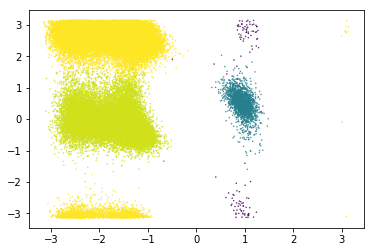

In [19]:
### Clustering result:

result = np.loadtxt('./torsion.clustered.txt')
print(result.shape)

plt.scatter(x=result[:,0], y=result[:,1], c=result[:,2], alpha=1.0, s=0.2)

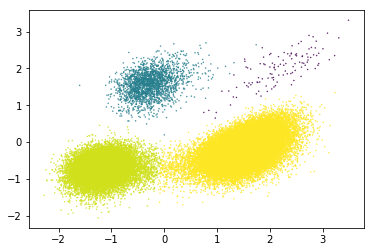

In [20]:
### Dimensionality reduction: IDioM Embedding

idiom_embed = np.loadtxt('./cv.membership.txt')[:,:2]

plt.scatter(x=idiom_embed[:,0], y=idiom_embed[:,1], c=result[:,2], alpha=1.0, s=0.2)